# Model Training 

# edge_attr: 0 = sequence, 1 = sync_req, 2 = sync_resp, 3 = async_req


In [1]:
# Installer PyTorch Geometric sur Kaggle
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.1 MB/s eta 0:00:00


In [2]:
!python -c "import torch; print(torch.__version__)"


2.6.0+cu124


In [3]:
!pip uninstall -y torch-scatter


Found existing installation: torch-scatter 2.1.2+pt21cpu
Uninstalling torch-scatter-2.1.2+pt21cpu:
  Successfully uninstalled torch-scatter-2.1.2+pt21cpu


In [4]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 82.2 MB/s eta 0:00:00


In [5]:
from torch_scatter import scatter


**debug**

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
import os
import json
from tqdm import tqdm
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()

def label_from_error_type(error_type: str) -> int:
    return 0 if error_type == 'normal' else 1

def json_trace_to_pyg_data(trace: dict, n_edge_types: int = None) -> Data:
    scaler = StandardScaler()
    node_info = scaler.fit_transform(trace['node_info'])
    edge_index = torch.tensor(trace['edge_index'], dtype=torch.long).t().contiguous()
    edge_attr_raw = torch.tensor(trace['edge_attr'], dtype=torch.long)

    if n_edge_types is None:
        n_edge_types = edge_attr_raw.max().item() + 1
    elif edge_attr_raw.max().item() >= n_edge_types:
        raise ValueError(f"Invalid edge type: {edge_attr_raw.max().item()} >= {n_edge_types}")

    edge_attr = F.one_hot(edge_attr_raw, num_classes=n_edge_types)
    x = torch.tensor(node_info, dtype=torch.float)
    y = torch.tensor([label_from_error_type(trace['error_trace_type'])], dtype=torch.long)
    return Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        trace_id=trace['trace_id'],
        error_type=trace['error_trace_type']
    )

def load_all_graphs(data_dir: str) -> tuple:
    dataset = []
    max_edge_type = 0
    traces = []
    for file_name in sorted(os.listdir(data_dir)):
        if not file_name.startswith("process") or not file_name.endswith(".jsons"):
            continue
        file_path = os.path.join(data_dir, file_name)
        with open(file_path, "r") as f:
            for line in tqdm(f, desc=f"Loading {file_name}"):
                try:
                    trace = json.loads(line)
                    max_edge_type = max(max_edge_type, max(trace['edge_attr']))
                    traces.append(trace)
                except json.JSONDecodeError:
                    print(f"Skipping corrupted JSON line in {file_name}")
                    continue
    n_edge_types = max_edge_type + 1 
    print(f"Detected {n_edge_types} edge types.")
    for trace in traces:
        data = json_trace_to_pyg_data(trace, n_edge_types)
        dataset.append(data)
    return dataset, n_edge_types



/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [7]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split, Subset
import logging
import torch

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()

class BaseADDataset:
    def __init__(self, root: str):
        self.root = root
        self.n_classes = 2
        self.normal_classes = (0,)
        self.outlier_classes = (1,)
        self.train_set = None
        self.test_set = None

    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0):
        pass

    def __repr__(self):
        return self.__class__.__name__

class MyGraphDataset(BaseADDataset):
    def __init__(self, train_set, test_set, root=''):
        super().__init__(root)
        self.train_set = train_set
        self.test_set = test_set

    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0):
        train_loader = DataLoader(self.train_set, batch_size=batch_size, shuffle=shuffle_train, 
                                 num_workers=num_workers, pin_memory=True)
        test_loader = DataLoader(self.test_set, batch_size=batch_size, shuffle=shuffle_test, 
                                num_workers=num_workers, pin_memory=True)
        return train_loader, test_loader

In [8]:
import torch
import torch.nn as nn
from torch_geometric.utils import to_dense_adj, scatter

class AttrProxy:
    def __init__(self, module, prefix):
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        return getattr(self.module, self.prefix + str(i))

class Propogator(nn.Module):
    def __init__(self, state_dim, n_edge_types):
        super(Propogator, self).__init__()
        self.n_edge_types = n_edge_types
        self.reset_gate = nn.Sequential(
            nn.Linear(state_dim * 3, state_dim),
            nn.Sigmoid()
        )
        self.update_gate = nn.Sequential(
            nn.Linear(state_dim * 3, state_dim),
            nn.Sigmoid()
        )
        self.transform = nn.Sequential(
            nn.Linear(state_dim * 3, state_dim),
            nn.Tanh()
        )

    def forward(self, state_in, state_out, state_cur, A):
        A_in = A[:, :, :A.shape[1] * self.n_edge_types]
        A_out = A[:, :, A.shape[1] * self.n_edge_types:]
        a_in = torch.bmm(A_in, state_in)
        a_out = torch.bmm(A_out, state_out)
        a = torch.cat((a_in, a_out, state_cur), dim=2)
        r = self.reset_gate(a)
        z = self.update_gate(a)
        joined_input = torch.cat((a_in, a_out, r * state_cur), dim=2)
        h_hat = self.transform(joined_input)
        output = (1 - z) * state_cur + z * h_hat
        return output

class GGNN(nn.Module):
    def __init__(self, opt):
        super(GGNN, self).__init__()
        assert opt.state_dim >= opt.annotation_dim, 'state_dim must be >= annotation_dim'
        self.state_dim = opt.state_dim
        self.annotation_dim = opt.annotation_dim
        self.n_edge_types = opt.n_edge_types
        self.n_steps = opt.n_steps

        for i in range(self.n_edge_types):
            in_fc = nn.Linear(self.state_dim, self.state_dim)
            out_fc = nn.Linear(self.state_dim, self.state_dim)
            self.add_module(f"in_{i}", in_fc)
            self.add_module(f"out_{i}", out_fc)

        self.in_fcs = AttrProxy(self, "in_")
        self.out_fcs = AttrProxy(self, "out_")
        self.propogator = Propogator(self.state_dim, self.n_edge_types)
        self.out = nn.Sequential(
            nn.Linear(self.state_dim + self.annotation_dim, self.state_dim),
            nn.Tanh()
        )
        self.center = nn.Parameter(torch.randn(self.state_dim))
        self._initialization()

    def _initialization(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.shape[0], dtype=torch.long, device=x.device)

        batch_size = data.num_graphs if hasattr(data, 'num_graphs') else 1
        node_counts = torch.bincount(batch, minlength=batch_size) if batch.numel() > 0 else torch.tensor([x.shape[0]], device=x.device)
        max_nodes = node_counts.max().item() if node_counts.numel() > 0 else x.shape[0]
     

        if batch.max().item() + 1 > batch_size:
            raise ValueError("Invalid batch indices")
        if node_counts.sum() != x.shape[0]:
            raise ValueError("Node count mismatch in batch")

        batch_padded = torch.zeros(batch_size * max_nodes, dtype=torch.long, device=x.device)
        node_mask = torch.zeros(batch_size * max_nodes, dtype=torch.bool, device=x.device)
        node_idx = 0
        for b in range(batch_size):
            num_nodes = node_counts[b]
            if num_nodes > 0:
                batch_padded[node_idx:node_idx + num_nodes] = b
                node_mask[node_idx:node_idx + num_nodes] = 1
                node_idx += num_nodes
       

        prop_state = torch.zeros(batch_size, max_nodes, self.state_dim, device=x.device)

        state = torch.zeros(batch_size, max_nodes, self.annotation_dim, device=x.device)
        node_idx = 0
        for b in range(batch_size):
            num_nodes = node_counts[b]
            if num_nodes > 0:
                state[b, :num_nodes] = x[node_idx:node_idx + num_nodes]
                node_idx += num_nodes

        A = self._to_adj_matrix(edge_index, edge_attr, batch, max_nodes)

        for i_step in range(self.n_steps):
            in_states = []
            out_states = []
            for i in range(self.n_edge_types):
                in_states.append(self.in_fcs[i](prop_state))
                out_states.append(self.out_fcs[i](prop_state))
            in_states = torch.stack(in_states, dim=2)
            out_states = torch.stack(out_states, dim=2)
            in_states = in_states.view(batch_size, max_nodes * self.n_edge_types, self.state_dim)
            out_states = out_states.view(batch_size, max_nodes * self.n_edge_types, self.state_dim)
            prop_state = self.propogator(in_states, out_states, prop_state, A)

        join_state = torch.cat((prop_state, state), dim=2)
        output = self.out(join_state)

        output_flat = output.view(-1, self.state_dim)

        output = scatter(output_flat[node_mask], batch_padded[node_mask], dim=0, dim_size=batch_size, reduce="mean")
        return output

    def _to_adj_matrix(self, edge_index, edge_attr, batch, max_nodes):
        batch_size = batch.max().item() + 1 if batch.numel() > 0 else 1
        A = torch.zeros(batch_size, max_nodes, max_nodes * self.n_edge_types * 2, device=edge_index.device)
        for b in range(batch_size):
            mask = batch == b
            edge_mask = mask[edge_index[0]] & mask[edge_index[1]]
            b_edge_index = edge_index[:, edge_mask]
            b_edge_attr = edge_attr[edge_mask]
            if b_edge_index.numel() == 0:
                continue
            b_edge_index = b_edge_index - b_edge_index.min()
            for edge_type in range(self.n_edge_types):
                type_mask = b_edge_attr[:, edge_type].bool()
                type_edges = b_edge_index[:, type_mask]
                if type_edges.shape[1] > 0:
                    A_in = to_dense_adj(type_edges, max_num_nodes=max_nodes).squeeze(0)
                    A[b, :, edge_type * max_nodes:(edge_type + 1) * max_nodes] = A_in
                    A_out = to_dense_adj(type_edges.flip(0), max_num_nodes=max_nodes).squeeze(0)
                    A[b, :, (self.n_edge_types + edge_type) * max_nodes:(self.n_edge_types + edge_type + 1) * max_nodes] = A_out
        return A


In [9]:
import torch
import torch.optim as optim
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import time
from torch.utils.data import Subset, DataLoader

class DeepSVDDTrainer:
    def __init__(self, objective, R, c, nu: float, optimizer_name: str = 'adam', 
                 lr: float = 0.001, n_epochs: int = 150, lr_milestones: tuple = (), 
                 batch_size: int = 128, weight_decay: float = 1e-6, device: str = 'cuda', 
                 n_jobs_dataloader: int = 0):
        assert objective in ('one-class', 'soft-boundary'), f"Invalid objective: {objective}"
        self.objective = objective
        self.R = torch.tensor(R, device=device) if R is not None else torch.tensor(0.0, device=device)
        self.c = torch.tensor(c, device=device) if c is not None else None
        self.nu = nu
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.n_epochs = n_epochs
        self.lr_milestones = lr_milestones
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.device = device
        self.n_jobs_dataloader = n_jobs_dataloader
        self.warm_up_n_epochs = 6
        self.train_time = None
        self.test_auc = None
        self.test_time = None
        self.test_scores = None
        self.y_val_pred = None

    def train(self, dataset, net):
        net = net.to(self.device)
        train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)
        optimizer = optim.Adam(net.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                              amsgrad=self.optimizer_name == 'amsgrad')
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.lr_milestones, gamma=0.1)

        if self.c is None:
            print('INFO: Initializing center c...')
            self.c = self.init_center_c(train_loader, net)

        print('INFO: Starting training...')
        start_time = time.time()
        net.train()
        # Ajout de tqdm pour la barre de progression
        for epoch in tqdm(range(self.n_epochs), desc="Training Epochs", unit="epoch"):
            scheduler.step()
            if epoch in self.lr_milestones:
                print(f'INFO:   LR scheduler: new learning rate is {scheduler.get_last_lr()[0]:g}')
            loss_epoch = 0.0
            n_batches = 0
            epoch_start_time = time.time()
            for batch_idx, batch in enumerate(train_loader):
                batch = batch.to(self.device)
                
                optimizer.zero_grad()
                outputs = net(batch)
                if outputs.shape != (batch.num_graphs, net.state_dim):
                    print(f"ERROR: Unexpected output shape: {outputs.shape} != [{batch.num_graphs}, {net.state_dim}]")
                    raise ValueError("Output shape mismatch")
                if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                    print("ERROR: NaN or Inf in outputs")
                    raise ValueError("Invalid outputs")
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                if self.objective == 'soft-boundary':
                    scores = dist - self.R ** 2
                    loss = self.R ** 2 + (1 / self.nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                else:
                    loss = torch.mean(dist)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                optimizer.step()
                if self.objective == 'soft-boundary' and epoch >= self.warm_up_n_epochs:
                    self.R.data = torch.tensor(self.get_radius(dist, self.nu), device=self.device)
                loss_epoch += loss.item()
                n_batches += 1
            epoch_train_time = time.time() - epoch_start_time
            # Mise à jour de la barre de progression avec loss et R
            tqdm.write(f'Epoch {epoch + 1}/{self.n_epochs}\t Time: {epoch_train_time:.3f}\t Loss: {loss_epoch / n_batches:.8f}\t R: {self.R:.4f}')

        self.train_time = time.time() - start_time
        print(f'INFO: Training time: {self.train_time:.3f}')
        return net
        
    def test(self, dataset, net):
        net = net.to(self.device)
        if self.c is None:
            print('INFO: Center c is None, initializing before testing...')
            train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)
            self.c = self.init_center_c(train_loader, net)
        
        _, test_loader = dataset.loaders(batch_size=self.batch_size, shuffle_test=False, 
                                         num_workers=self.n_jobs_dataloader)
        print('INFO: Starting testing...')
        start_time = time.time()
        idx_label_score = []
        net.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                batch = batch.to(self.device)
                outputs = net(batch)
                if outputs.shape != (batch.num_graphs, net.state_dim):
                    print(f"ERROR: Unexpected output shape: {outputs.shape} != [{batch.num_graphs}, {net.state_dim}]")
                    raise ValueError("Output shape mismatch")
                if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                    print("ERROR: NaN or Inf in outputs")
                    raise ValueError("Invalid outputs")
                labels = batch.y
                trace_ids = batch.trace_id
                error_types = batch.error_type
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                scores = dist - self.R ** 2 if self.objective == 'soft-boundary' else dist
                idx_label_score += list(zip(trace_ids, labels.cpu().numpy().tolist(),
                                            scores.cpu().numpy().tolist(), error_types))

        self.test_time = time.time() - start_time
        print(f'INFO: Testing time: {self.test_time:.3f}')
        trace_ids, labels, scores, error_types = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)
        print(f"DEBUG: Labels shape: {labels.shape}, Scores shape: {scores.shape}, Labels unique: {np.unique(labels, return_counts=True)}")

        try:
            self.test_auc = roc_auc_score(labels, scores)
            print(f'INFO: Test set AUC: {100. * self.test_auc:.2f}%')
        except ValueError as e:
            print(f"ERROR: ROC AUC computation failed: {e}")
            self.test_auc = 0.0

        y_pred = (scores > np.quantile(scores, 1 - self.nu)).astype(int)
        self.y_val_pred = y_pred
        precision = precision_score(labels, y_pred, zero_division=0)
        recall = recall_score(labels, y_pred, zero_division=0)
        f1 = f1_score(labels, y_pred, zero_division=0)
        accuracy = accuracy_score(labels, y_pred)
        print(f'INFO: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
        return y_pred, f1, precision, recall, accuracy, scores

    def init_center_c(self, train_loader, net, eps=0.1):
        n_samples = 0
        c = torch.zeros(net.state_dim, device=self.device)
        net.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(train_loader):
                batch = batch.to(self.device)
                outputs = net(batch)
                if outputs.shape != (batch.num_graphs, net.state_dim):
                    print(f"ERROR: Unexpected output shape: {outputs.shape} != [{batch.num_graphs}, {net.state_dim}]")
                    raise ValueError("Output shape mismatch")
                n_samples += outputs.shape[0]
                c += torch.sum(outputs, dim=0)
        c /= n_samples
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c

    def get_radius(self, dist: torch.Tensor, nu: float):
        return np.quantile(np.sqrt(dist.clone().detach().cpu().numpy()), 1 - nu)

In [10]:
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import json


# Define DeepSVDD class (as provided)
class DeepSVDD:
    def __init__(self, opt):
        self.objective = 'soft-boundary'
        assert (0 < opt.nu <= 1), "For hyperparameter nu, it must hold: 0 < nu <= 1."
        self.nu = opt.nu
        self.R = 0.0
        self.c = None
        self.opt = opt
        self.net = None
        self.trainer = None
        self.optimizer_name = None
        self.results = {
            'train_time': None,
            'test_auc': None,
            'test_time': None,
            'test_scores': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1_score': None,
        }

    def set_network(self, net):
        self.net = net

    def train(self, dataset, optimizer_name: str = 'adam', lr: float = 0.001, n_epochs: int = 50, 
              lr_milestones: tuple = (), batch_size: int = 128, weight_decay: float = 1e-6, 
              device: str = 'cuda', n_jobs_dataloader: int = 0):
        self.optimizer_name = optimizer_name
        self.trainer = DeepSVDDTrainer(
            objective=self.objective,
            R=self.R,
            c=self.c,
            nu=self.nu,
            optimizer_name=optimizer_name,
            lr=lr,
            n_epochs=n_epochs,
            lr_milestones=lr_milestones,
            batch_size=batch_size,
            weight_decay=weight_decay,
            device=device,
            n_jobs_dataloader=n_jobs_dataloader
        )
        self.net = self.trainer.train(dataset, self.net)
        self.R = float(self.trainer.R.cpu().numpy())
        self.c = self.trainer.c.cpu().numpy().tolist()
        self.results['train_time'] = self.trainer.train_time

    def test(self, dataset, device: str = 'cuda', n_jobs_dataloader: int = 0):
        if self.trainer is None:
            self.trainer = DeepSVDDTrainer(
                objective=self.objective,
                R=self.R,
                c=self.c,
                nu=self.nu,
                device=device,
                n_jobs_dataloader=n_jobs_dataloader
            )
        y_pred, f1_score_val, precision_score_val, recall_score_val, accuracy_val, scores = self.trainer.test(dataset, self.net)
        self.results['test_auc'] = self.trainer.test_auc
        self.results['test_time'] = self.trainer.test_time
        self.results['test_scores'] = self.trainer.test_scores
        self.results['accuracy'] = accuracy_val
        self.results['precision'] = precision_score_val
        self.results['recall'] = recall_score_val
        self.results['f1_score'] = f1_score_val
        return y_pred, f1_score_val, precision_score_val, recall_score_val, accuracy_val, scores

    def save_model(self, export_model):
        net_dict = self.net.state_dict()
        torch.save({
            'R': self.R,
            'c': self.c,
            'net_dict': net_dict,
        }, export_model)

    def save_results(self, export_json):
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)

    def load_model(self, model_path):
        model_dict = torch.load(model_path)
        self.R = model_dict['R']
        self.c = model_dict['c']
        self.net.load_state_dict(model_dict['net_dict'])



In [11]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
data_dir = "/kaggle/input/graphdata/graph_data/raw"
dataset, n_edge_types = load_all_graphs(data_dir)
print(f"[INFO] Loaded {len(dataset)} graphs with {n_edge_types} edge types.")

Loading process0.jsons: 16559it [00:12, 1342.14it/s]
Loading process1.jsons: 16561it [00:10, 1506.85it/s]
Loading process2.jsons: 16561it [00:11, 1438.92it/s]
Loading process3.jsons: 16561it [00:10, 1637.32it/s]
Loading process4.jsons: 16561it [00:10, 1557.33it/s]
Loading process5.jsons: 16561it [00:11, 1415.37it/s]
Loading process6.jsons: 16561it [00:12, 1286.28it/s]
Loading process7.jsons: 16560it [00:06, 2455.87it/s]


Detected 4 edge types.
[INFO] Loaded 132485 graphs with 4 edge types.


In [12]:
# Split dataset
normal_graphs = [d for d in dataset if d.y.item() == 0]
anomaly_graphs = [d for d in dataset if d.y.item() == 1]
np.random.seed(42)
np.random.shuffle(normal_graphs)
np.random.shuffle(anomaly_graphs)

train_set = normal_graphs[:10000]
test_set = normal_graphs[10000:12500] + anomaly_graphs[:2500]

# train_size = int(0.8 * len(normal_graphs))
# test_size = len(normal_graphs) - train_size
# train_set, test_normal = random_split(normal_graphs, [train_size, test_size])
# test_set = list(test_normal) + anomaly_graphs

my_dataset = MyGraphDataset(train_set, test_set)
print(len(normal_graphs))
print(len(anomaly_graphs))
print(f"[INFO] Train set size: {len(train_set)}, Test set size: {len(test_set)}")


109151
23334
[INFO] Train set size: 10000, Test set size: 5000


In [13]:
# Log dataset details
train_labels = [d.y.item() for d in train_set]
train_node_counts = [d.x.shape[0] for d in train_set]
print(f"[INFO] Train set labels: {np.unique(train_labels, return_counts=True)}")
print(f"[INFO] Train set node counts (first 10): {train_node_counts[:10]}")
test_labels = [d.y.item() for d in test_set]
test_node_counts = [d.x.shape[0] for d in test_set]
print(f"[INFO] Test set labels: {np.unique(test_labels, return_counts=True)}")
print(f"[INFO] Test set node counts (first 10): {test_node_counts[:10]}")


[INFO] Train set labels: (array([0]), array([10000]))
[INFO] Train set node counts (first 10): [157, 4, 27, 11, 173, 26, 7, 27, 10, 28]
[INFO] Test set labels: (array([0, 1]), array([2500, 2500]))
[INFO] Test set node counts (first 10): [311, 4, 173, 378, 10, 550, 311, 6, 378, 27]


In [14]:
# Configuration
class Opt:
    def __init__(self, n_edge_types=4):
        self.state_dim = 32
        self.annotation_dim = 7
        self.n_edge_types = n_edge_types
        self.n_steps = 5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.nu = 0.1
        self.lr = 0.001
        self.n_epochs = 30
        self.batch_size = 128
        self.weight_decay = 1e-6

In [15]:
# Initialize model and DeepSVDD
opt = Opt(n_edge_types=n_edge_types)
net = GGNN(opt).to(opt.device)
deep_svdd = DeepSVDD(opt)
deep_svdd.set_network(net)

# Train
print("[INFO] Starting training...")
deep_svdd.train(my_dataset, optimizer_name='adam', lr=opt.lr, n_epochs=opt.n_epochs, 
                batch_size=opt.batch_size, weight_decay=opt.weight_decay, device=opt.device)

# Test
print("[INFO] Starting testing...")
y_pred, f1, precision, recall, accuracy, scores = deep_svdd.test(my_dataset, device=opt.device)

# Save model and results
deep_svdd.save_model("deeptralog_model.pt")
deep_svdd.save_results("deeptralog_results.json")
print("[INFO] Saved model to deeptralog_model.pt and results to deeptralog_results.json")
print(f"[INFO] Results: {deep_svdd.results}")

[INFO] Starting training...
INFO: Initializing center c...
INFO: Starting training...


Training Epochs:   0%|          | 0/30 [00:00<?, ?epoch/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Training Epochs:   3%|▎         | 1/30 [13:10<6:21:59, 790.32s/epoch]

Epoch 1/30	 Time: 790.308	 Loss: 0.68339587	 R: 0.0000


Training Epochs:   7%|▋         | 2/30 [26:17<6:07:57, 788.47s/epoch]

Epoch 2/30	 Time: 787.167	 Loss: 0.00006242	 R: 0.0000


Training Epochs:  10%|█         | 3/30 [39:17<5:53:05, 784.67s/epoch]

Epoch 3/30	 Time: 780.136	 Loss: 0.00000525	 R: 0.0000


Training Epochs:  13%|█▎        | 4/30 [52:17<5:39:10, 782.70s/epoch]

Epoch 4/30	 Time: 779.677	 Loss: 0.00000487	 R: 0.0000


Training Epochs:  17%|█▋        | 5/30 [1:04:57<5:22:47, 774.70s/epoch]

Epoch 5/30	 Time: 760.502	 Loss: 0.00000399	 R: 0.0000


Training Epochs:  20%|██        | 6/30 [1:17:49<5:09:26, 773.60s/epoch]

Epoch 6/30	 Time: 771.457	 Loss: 0.00000635	 R: 0.0000


Training Epochs:  23%|██▎       | 7/30 [1:30:33<4:55:23, 770.59s/epoch]

Epoch 7/30	 Time: 764.408	 Loss: 0.00000620	 R: 0.0012


Training Epochs:  27%|██▋       | 8/30 [1:43:22<4:42:18, 769.93s/epoch]

Epoch 8/30	 Time: 768.500	 Loss: 0.00000403	 R: 0.0027


Training Epochs:  30%|███       | 9/30 [1:56:15<4:29:50, 770.99s/epoch]

Epoch 9/30	 Time: 773.310	 Loss: 0.00001941	 R: 0.0007


Training Epochs:  33%|███▎      | 10/30 [2:09:19<4:18:20, 775.03s/epoch]

Epoch 10/30	 Time: 784.091	 Loss: 0.00001792	 R: 0.0029


Training Epochs:  37%|███▋      | 11/30 [2:22:11<4:05:07, 774.09s/epoch]

Epoch 11/30	 Time: 771.929	 Loss: 0.00009733	 R: 0.0012


Training Epochs:  40%|████      | 12/30 [2:35:05<3:52:11, 773.95s/epoch]

Epoch 12/30	 Time: 773.624	 Loss: 0.00000337	 R: 0.0004


Training Epochs:  43%|████▎     | 13/30 [2:48:08<3:40:04, 776.73s/epoch]

Epoch 13/30	 Time: 783.133	 Loss: 0.00000637	 R: 0.0003


Training Epochs:  47%|████▋     | 14/30 [3:00:26<3:24:03, 765.22s/epoch]

Epoch 14/30	 Time: 738.601	 Loss: 0.00000396	 R: 0.0005


Training Epochs:  50%|█████     | 15/30 [3:13:26<3:12:21, 769.44s/epoch]

Epoch 15/30	 Time: 779.230	 Loss: 0.00002562	 R: 0.0007


Training Epochs:  53%|█████▎    | 16/30 [3:26:26<3:00:18, 772.78s/epoch]

Epoch 16/30	 Time: 780.533	 Loss: 0.00015469	 R: 0.0017


Training Epochs:  57%|█████▋    | 17/30 [3:39:18<2:47:21, 772.43s/epoch]

Epoch 17/30	 Time: 771.601	 Loss: 0.00000620	 R: 0.0003


Training Epochs:  60%|██████    | 18/30 [3:52:30<2:35:42, 778.52s/epoch]

Epoch 18/30	 Time: 792.697	 Loss: 0.00000506	 R: 0.0006


Training Epochs:  63%|██████▎   | 19/30 [4:05:13<2:21:51, 773.75s/epoch]

Epoch 19/30	 Time: 762.640	 Loss: 0.00002259	 R: 0.0012


Training Epochs:  67%|██████▋   | 20/30 [4:17:57<2:08:29, 770.92s/epoch]

Epoch 20/30	 Time: 764.307	 Loss: 0.00000500	 R: 0.0007


Training Epochs:  70%|███████   | 21/30 [4:30:27<1:54:41, 764.56s/epoch]

Epoch 21/30	 Time: 749.723	 Loss: 0.00000794	 R: 0.0027


Training Epochs:  73%|███████▎  | 22/30 [4:43:09<1:41:51, 763.89s/epoch]

Epoch 22/30	 Time: 762.318	 Loss: 0.00000583	 R: 0.0007


Training Epochs:  77%|███████▋  | 23/30 [4:56:09<1:29:39, 768.44s/epoch]

Epoch 23/30	 Time: 779.046	 Loss: 0.00000253	 R: 0.0004


Training Epochs:  80%|████████  | 24/30 [5:08:42<1:16:23, 763.99s/epoch]

Epoch 24/30	 Time: 753.598	 Loss: 0.00001024	 R: 0.0010


Training Epochs:  83%|████████▎ | 25/30 [5:21:54<1:04:22, 772.43s/epoch]

Epoch 25/30	 Time: 792.126	 Loss: 0.00000565	 R: 0.0009


Training Epochs:  87%|████████▋ | 26/30 [5:34:53<51:37, 774.36s/epoch]  

Epoch 26/30	 Time: 778.873	 Loss: 0.00000813	 R: 0.0006


Training Epochs:  90%|█████████ | 27/30 [5:47:19<38:17, 765.73s/epoch]

Epoch 27/30	 Time: 745.578	 Loss: 0.00004043	 R: 0.0045


Training Epochs:  93%|█████████▎| 28/30 [5:59:57<25:26, 763.43s/epoch]

Epoch 28/30	 Time: 758.052	 Loss: 0.00003694	 R: 0.0039


Training Epochs:  97%|█████████▋| 29/30 [6:12:33<12:41, 761.27s/epoch]

Epoch 29/30	 Time: 756.217	 Loss: 0.00027341	 R: 0.0043


Training Epochs: 100%|██████████| 30/30 [6:25:19<00:00, 770.63s/epoch]


Epoch 30/30	 Time: 765.499	 Loss: 0.00007538	 R: 0.0013
INFO: Training time: 23119.025
[INFO] Starting testing...
INFO: Starting testing...
INFO: Testing time: 226.330
DEBUG: Labels shape: (5000,), Scores shape: (5000,), Labels unique: (array([0, 1]), array([2500, 2500]))
INFO: Test set AUC: 50.95%
INFO: Accuracy: 0.5068, Precision: 0.5340, Recall: 0.1068, F1-Score: 0.1780
[INFO] Saved model to deeptralog_model.pt and results to deeptralog_results.json
[INFO] Results: {'train_time': 23119.02492403984, 'test_auc': 0.509522, 'test_time': 226.33049750328064, 'test_scores': None, 'accuracy': 0.5068, 'precision': 0.534, 'recall': 0.1068, 'f1_score': 0.178}


In [16]:
import numpy as np

y_true = np.array(test_labels)
scores = np.array(scores)

# Vérifier les scores pour les anomalies
print("Mean score anomaly:", np.mean(scores[y_true == 1]))
print("Mean score normal:", np.mean(scores[y_true == 0]))


Mean score anomaly: 2.0238151509602174e-06
Mean score normal: 1.984756775709684e-06


[INFO] Sample predictions vs. true labels (first 10 test graphs):
[INFO] Graph 0: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 1: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 2: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 3: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 4: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 5: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 6: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 7: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 8: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000
[INFO] Graph 9: True Label=0 (0=Normal, 1=Anomaly), Predicted Label=0, Score=0.0000


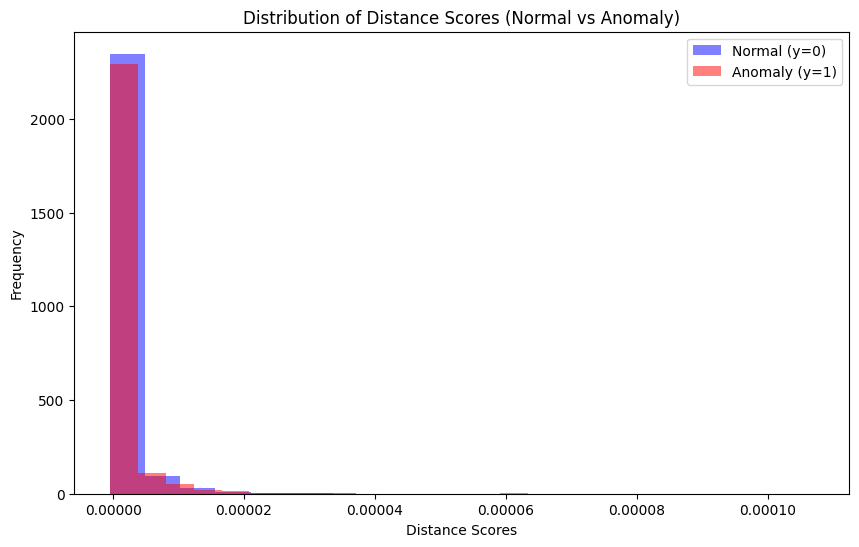

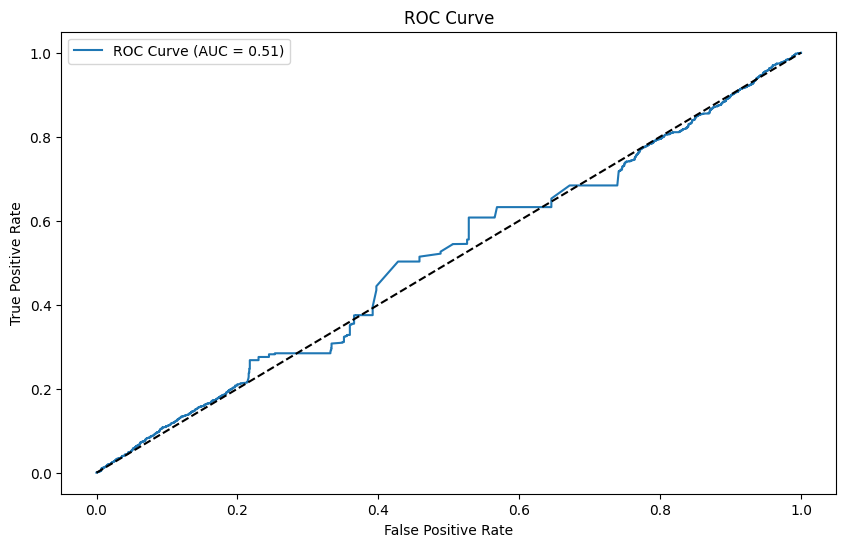

In [17]:
# Display predictions vs. true labels (first 10 test graphs)
print("[INFO] Sample predictions vs. true labels (first 10 test graphs):")
for i in range(min(10, len(test_set))):
    true_label = test_labels[i]
    pred_label = y_pred[i]
    score = scores[i]
    print(f"[INFO] Graph {i}: True Label={true_label} (0=Normal, 1=Anomaly), Predicted Label={pred_label}, Score={score:.4f}")

# Visualize distance scores
plt.figure(figsize=(10, 6))
normal_scores = [s for s, l in zip(scores, test_labels) if l == 0]
anomaly_scores = [s for s, l in zip(scores, test_labels) if l == 1]
plt.hist(normal_scores, bins=20, alpha=0.5, label='Normal (y=0)', color='blue')
plt.hist(anomaly_scores, bins=20, alpha=0.5, label='Anomaly (y=1)', color='red')
plt.xlabel('Distance Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Distance Scores (Normal vs Anomaly)')
plt.legend()
plt.savefig("distance_scores.png")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, scores)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {deep_svdd.results["test_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig("roc_curve.png")
plt.show()


In [18]:
# start_idx = 2500
# end_idx = min(3000, len(test_set))

# for i in range(start_idx, end_idx):
#     true_label = test_labels[i]
#     pred_label = y_pred[i]
#     score = scores[i]
#     print(f"[INFO] Graph {i}: True Label={true_label} (0=Normal, 1=Anomaly), Predicted Label={pred_label}, Score={score:.4f}")

In [19]:
# if __name__ == "__main__":
#     # Set random seed
#     torch.manual_seed(42)
#     np.random.seed(42)

#     # Load dataset
#     data_dir = "/kaggle/input/graphdata/graph_data/raw"
#     dataset, n_edge_types = load_all_graphs(data_dir)
#     print(f"[INFO] Loaded {len(dataset)} graphs with {n_edge_types} edge types.")

#     # Split dataset
#     normal_graphs = [d for d in dataset if d.y.item() == 0]
#     anomaly_graphs = [d for d in dataset if d.y.item() == 1]
#     train_size = int(0.8 * len(normal_graphs))
#     test_size = len(normal_graphs) - train_size
#     train_set, test_normal = random_split(normal_graphs, [train_size, test_size])
#     test_set = list(test_normal) + anomaly_graphs
#     my_dataset = MyGraphDataset(train_set, test_set)

#     # Log dataset details
#     print(f"[INFO] Train set size: {len(train_set)}, Test set size: {len(test_set)}")
#     train_labels = [d.y.item() for d in train_set]
#     train_node_counts = [d.x.shape[0] for d in train_set]
#     print(f"[INFO] Train set labels: {np.unique(train_labels, return_counts=True)}")
#     print(f"[INFO] Train set node counts (first 10): {train_node_counts[:10]}")
#     test_labels = [d.y.item() for d in test_set]
#     test_node_counts = [d.x.shape[0] for d in test_set]
#     print(f"[INFO] Test set labels: {np.unique(test_labels, return_counts=True)}")
#     print(f"[INFO] Test set node counts (first 10): {test_node_counts[:10]}")

#     # Check for class balance
#     if len(np.unique(test_labels)) < 2:
#         print("[ERROR] Test set has only one class. AUC will fail.")
#         raise ValueError("Test set must contain both normal (y=0) and anomaly (y=1) graphs")

#     # Initialize model and DeepSVDD
#     opt = Opt(n_edge_types=n_edge_types)
#     net = GGNN(opt).to(opt.device)
#     deep_svdd = DeepSVDD(opt)
#     deep_svdd.set_network(net)

#     # Train
#     print("[INFO] Starting training...")
#     deep_svdd.train(my_dataset, optimizer_name='adam', lr=opt.lr, n_epochs=opt.n_epochs, 
#                     batch_size=opt.batch_size, weight_decay=opt.weight_decay, device=opt.device)

#     # Test
#     print("[INFO] Starting testing...")
#     y_pred, f1, precision, recall, accuracy, scores = deep_svdd.test(my_dataset, device=opt.device)

#     # Save model and results
#     deep_svdd.save_model("deeptralog_model.pt")
#     deep_svdd.save_results("deeptralog_results.json")
#     print("[INFO] Saved model to deeptralog_model.pt and results to deeptralog_results.json")
#     print(f"[INFO] Results: {deep_svdd.results}")

#     # Display predictions vs. true labels (first 10 test graphs)
#     print("[INFO] Sample predictions vs. true labels (first 10 test graphs):")
#     for i in range(min(10, len(test_set))):
#         true_label = test_labels[i]
#         pred_label = y_pred[i]
#         score = scores[i]
#         print(f"[INFO] Graph {i}: True Label={true_label} (0=Normal, 1=Anomaly), Predicted Label={pred_label}, Score={score:.4f}")

#     # Visualize distance scores
#     plt.figure(figsize=(10, 6))
#     normal_scores = [s for s, l in zip(scores, test_labels) if l == 0]
#     anomaly_scores = [s for s, l in zip(scores, test_labels) if l == 1]
#     plt.hist(normal_scores, bins=20, alpha=0.5, label='Normal (y=0)', color='blue')
#     plt.hist(anomaly_scores, bins=20, alpha=0.5, label='Anomaly (y=1)', color='red')
#     plt.xlabel('Distance Scores')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Distance Scores (Normal vs Anomaly)')
#     plt.legend()
#     plt.savefig("distance_scores.png")
#     plt.show()

#     # Plot ROC curve
#     fpr, tpr, _ = roc_curve(test_labels, scores)
#     plt.figure(figsize=(10, 6))
#     plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {deep_svdd.results["test_auc"]:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend()
#     plt.savefig("roc_curve.png")
#     plt.show()


In [20]:
# # Hypersphere Visualization (with perplexity fix and error_type handling)
# def visualize_hypersphere(deep_svdd, dataset, model_path="deeptralog_model.pt", results_path="deeptralog_results.json", 
#                          n_samples=1000, save_plot="hypersphere.png"):
#     logger.info('Starting hypersphere visualization...')
#     opt = deep_svdd.opt
#     device = opt.device

#     # Load model
#     deep_svdd.load_model(model_path)
#     net = deep_svdd.net.to(device)
#     net.eval()

#     # Load results
#     with open(results_path, 'r') as f:
#         results = json.load(f)
#     logger.info(f"Loaded results: AUC={results['test_auc']:.4f}, Accuracy={results['accuracy']:.4f}")

#     # Prepare test subset
#     test_subset = dataset.test_set[:min(n_samples, len(dataset.test_set))]
#     test_loader = DataLoader(test_subset, batch_size=opt.batch_size, shuffle=False)

#     # Collect embeddings, labels, error types
#     embeddings = []
#     labels = []
#     error_types = []
#     with torch.no_grad():
#         for batch in test_loader:
#             batch = batch.to(device)
#             output = net(batch)
#             embeddings.append(output.cpu().numpy())
#             labels.append(batch.y.cpu().numpy())
#             # Handle case where error_type may not exist
#             if hasattr(batch, 'error_type'):
#                 error_types.extend(batch.error_type)
#             else:
#                 error_types.extend([None] * batch.num_graphs)

#     embeddings = np.concatenate(embeddings, axis=0)
#     labels = np.concatenate(labels, axis=0)
#     logger.info(f"Collected {len(embeddings)} embeddings with shape {embeddings.shape}")

#     # t-SNE for 2D projection with dynamic perplexity
#     logger.info('Running t-SNE...')
#     perplexity = min(30, max(5, len(embeddings) - 1))  # Ensure perplexity < n_samples
#     tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
#     embeddings_2d = tsne.fit_transform(embeddings)

#     # Project center
#     c = np.array(deep_svdd.c)
#     c_2d = tsne.fit_transform(c.reshape(1, -1)).flatten()
#     R = deep_svdd.R

#     # Plot
#     plt.figure(figsize=(10, 8))
#     normal_idx = labels == 0
#     anomaly_idx = labels == 1

#     plt.scatter(embeddings_2d[normal_idx, 0], embeddings_2d[normal_idx, 1], 
#                 c='blue', label='Normal', alpha=0.6, s=50)
#     plt.scatter(embeddings_2d[anomaly_idx, 0], embeddings_2d[anomaly_idx, 1], 
#                 c='red', label='Anomalous', alpha=0.6, s=50)

#     circle = plt.Circle(c_2d, R, color='green', fill=False, linewidth=2, label='Hypersphere')
#     plt.gca().add_artist(circle)
#     plt.scatter(c_2d[0], c_2d[1], c='black', marker='x', s=200, label='Center')

#     plt.title(f'Deep SVDD Hypersphere (AUC: {results["test_auc"]:.4f})')
#     plt.xlabel('t-SNE Component 1')
#     plt.ylabel('t-SNE Component 2')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(save_plot)
#     plt.close()
#     logger.info(f"Saved plot to {save_plot}")

#     # Validate separation
#     normal_distances = np.sqrt(np.sum((embeddings_2d[normal_idx] - c_2d) ** 2, axis=1))
#     anomaly_distances = np.sqrt(np.sum((embeddings_2d[anomaly_idx] - c_2d) ** 2, axis=1))
#     normal_inside = np.mean(normal_distances <= R) if len(normal_distances) > 0 else 0
#     anomaly_outside = np.mean(anomaly_distances > R) if len(anomaly_distances) > 0 else 0
#     logger.info(f"Normal points inside hypersphere: {normal_inside:.2%}")
#     logger.info(f"Anomalous points outside hypersphere: {anomaly_outside:.2%}")

# # Configuration
# class Opt:
#     def __init__(self, n_edge_types=4):
#         self.state_dim = 32
#         self.annotation_dim = 7
#         self.n_edge_types = n_edge_types
#         self.n_steps = 5
#         self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.nu = 0.1
#         self.lr = 0.001
#         self.n_epochs = 10  # Increased for better training
#         self.batch_size = 10  # Matches Cell 4 for debugging
#         self.weight_decay = 1e-6

# # Initialize model and DeepSVDD
# opt = Opt(n_edge_types=4)
# net = GGNN(opt).to(opt.device)
# deep_svdd = DeepSVDD(opt)
# deep_svdd.set_network(net)

# # Debug dataset
# logger.info(f"Original train_set size: {len(my_dataset.train_set)}, test_set size: {len(my_dataset.test_set)}")
# train_labels = [d.y.item() for d in my_dataset.train_set]
# train_node_counts = [d.x.shape[0] for d in my_dataset.train_set]
# logger.info(f"Train set labels: {np.unique(train_labels, return_counts=True)}")
# logger.info(f"Train set node counts: {train_node_counts[:10]}... (first 10)")
# test_labels = [d.y.item() for d in my_dataset.test_set]
# test_node_counts = [d.x.shape[0] for d in my_dataset.test_set]
# logger.info(f"Original test set labels: {np.unique(test_labels, return_counts=True)}")
# logger.info(f"Original test set node counts: {test_node_counts}")

# # Create balanced train and test subsets
# train_subset = Subset(my_dataset.train_set, list(range(10)))
# my_dataset.train_set = train_subset

# # Ensure balanced test subset (5 normal, 5 anomaly)
# normal_graphs = [d for d in my_dataset.train_set if d.y.item() == 0]
# anomaly_graphs = [d for d in my_dataset.test_set if d.y.item() == 1]
# if not normal_graphs:
#     normal_graphs = [d for d in dataset if d.y.item() == 0]
# if not anomaly_graphs:
#     anomaly_graphs = [d for d in dataset if d.y.item() == 1]

# if len(normal_graphs) < 5 or len(anomaly_graphs) < 5:
#     logger.warning(f"Insufficient normal ({len(normal_graphs)}) or anomaly ({len(anomaly_graphs)}) graphs for balanced test set.")
#     test_subset = my_dataset.test_set[:10]
# else:
#     test_subset = normal_graphs[:5] + anomaly_graphs[:5]
# my_dataset.test_set = test_subset

# # Verify subsets
# train_labels = [d.y.item() for d in train_subset]
# train_node_counts = [d.x.shape[0] for d in train_subset]
# logger.info(f"Train subset labels: {np.unique(train_labels, return_counts=True)}")
# logger.info(f"Train subset node counts: {train_node_counts}")
# test_labels = [d.y.item() for d in test_subset]
# test_node_counts = [d.x.shape[0] for d in test_subset]
# logger.info(f"Test subset labels: {np.unique(test_labels, return_counts=True)}")
# logger.info(f"Test subset node counts: {test_node_counts}")

# if len(np.unique(test_labels)) < 2:
#     logger.error("Test subset has only one class. AUC will fail. Please check dataset labels.")
#     raise ValueError("Test subset must contain both normal (y=0) and anomaly (y=1) graphs")

# # Train and test
# logger.info("Starting training...")
# deep_svdd.train(my_dataset, optimizer_name='adam', lr=opt.lr, n_epochs=opt.n_epochs, 
#                 batch_size=opt.batch_size, weight_decay=opt.weight_decay, device=opt.device)

# logger.info("Starting testing...")
# y_pred, f1, precision, recall, accuracy, scores = deep_svdd.test(my_dataset, device=opt.device)

# # Save model and results
# deep_svdd.save_model("deeptralog_model.pt")
# deep_svdd.save_results("deeptralog_results.json")
# logger.info(f"Saved model to deeptralog_model.pt and results to deeptralog_results.json")
# logger.info(f"Results: {deep_svdd.results}")

# # Visualize distance scores
# plt.figure(figsize=(10, 6))
# normal_scores = [s for s, l in zip(scores, test_labels) if l == 0]
# anomaly_scores = [s for s, l in zip(scores, test_labels) if l == 1]
# plt.hist(normal_scores, bins=20, alpha=0.5, label='Normal (y=0)', color='blue')
# plt.hist(anomaly_scores, bins=20, alpha=0.5, label='Anomaly (y=1)', color='red')
# plt.xlabel('Distance Scores')
# plt.ylabel('Frequency')
# plt.title('Distribution of Distance Scores (Normal vs Anomaly)')
# plt.legend()
# plt.savefig("distance_scores.png")
# plt.show()

# # Plot ROC curve
# fpr, tpr, _ = roc_curve(test_labels, scores)
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {deep_svdd.results["test_auc"]:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.savefig("roc_curve.png")
# plt.show()

# # Hypersphere visualization
# visualize_hypersphere(deep_svdd, my_dataset, model_path="deeptralog_model.pt", 
#                       results_path="deeptralog_results.json", save_plot="hypersphere.png")

In [21]:
# # Hypersphere visualization
# visualize_hypersphere(deep_svdd, my_dataset, model_path="deeptralog_model.pt", 
#                       results_path="deeptralog_results.json", save_plot="hypersphere.png")